# Lower Dimension Quiescent Single Neuron Optimization Via SNN


Down the bottom of the [ipython Norse notebook](https://github.com/norse/notebooks/blob/master/single-neuron-experiments.ipynb) there is a remark that the optimization job actually doesn't perform that well.

I want to show that Spiking Neural Networks should be able to easily fit spike times in a single cell model if the dimensionality of the problem is reduced a lot.

To this end, I have remade the notebook so that:
* Weights of the outer SNN model, change the single-cell models' parameters. 
* When weights of the SNN model change single-cell model parameters, it is a simple way to elicit  the model to produce the right spike times.
* The single neuron model is more realistic Adexp, or Izhikevich models (using my own model code for dense Euler simulations, not tensor flow versions).
* The single neuron model is subject to unrealistic quiescent conditions. It has no synaptic input, its just a fixed current injection experiment.
* The right current amplitude to cause the target number of spikes is found via brute force each time inside the optimization loop, as this is surprisingly inexpensive.

 
If I can make this code succeeed I can evaluate the whole optimization job, and start to answer questions like:

* Does a more realistic single-cell model (with spike-timing adaptation) help?

* Does reducing the dimensionality of the optimization problem help? 



First of all, we will need to install Norse. Please run the cell below. Read on while it's running.
Run this if you want to install
```!pip install --quiet norse```


In [1]:

import torch
import norse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False



In [2]:
import norse
from jithub.models import model_classes
model = model_classes.ADEXPModel()
from neuronunit.optimization.model_parameters import MODEL_PARAMS
from neuronunit.tests.target_spike_current import SpikeCountSearch
import quantities as qt
from norse.torch.functional.lif import lif_step, LIFParameters, LIFState

In [3]:


class Neurons(torch.nn.Module):
    def __init__(self, weights, alpha, nspikes):
        super(Neurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        self.nspikes = nspikes
        self.lambda_vs = []
        self.lambda_is = []
        self.p = LIFParameters(alpha=alpha)

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []
        
    def forward(self, input_spikes):

        params = {}
        i = 0
        for k,j in MODEL_PARAMS['ADEXP'].items():
            wv = self.w_in.detach().numpy()[0]
            params[k] = np.mean([wv*j[0],wv*j[1]])
            i += 1
        model = model_classes.ADEXPModel()
        #params["celltype"] = int(params["celltype"])
        model.attrs = params
        
        observation = {}
        observation["value"] = self.nspikes
        scs = SpikeCountSearch(observation)
        target_current = scs.generate_prediction(model)
        inject_param = {
            "padding":0 * qt.ms,
            "delay": 0 * qt.ms,
            "amplitude": 900 * qt.pA,
            "duration": 1000 * qt.ms,
            "dt":0.25
        }
        try:
            inject_param["amplitude"] = target_current["value"]* qt.pA
            model.inject_square_current(**inject_param)
            vm = model.get_membrane_potential()
            #print(model.attrs)
            #print(self.w_in.detach().numpy())
            
            plt.plot(vm.times,vm)
            plt.show()

            concise_spk_time = model.get_spike_train()
        except:
            # some model parameters will cause try block to fail.
            concise_spk_time = []

        seq_length, batch_size, _ = input_spikes.shape

        hidden_size = self.hidden_size
        output_spikes = torch.zeros(seq_length, batch_size, hidden_size)

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)


        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

        for ts in range(seq_length):
            """
            This is where the optimized singular LIF model is solved for
            """
            z, s = lif_step(input_spikes[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            output_spikes[ts,:] = z

        return output_spikes, voltages, currents, concise_spk_time

## Step 1: A simple neuron model

The point neuron models supported by Norse are almost all variants of the Leaky-Integrate and Fire neuron model. It is however relatively easy to implement your own model. The library
is build in layers, here I show an example of how to use the functional API directly. To
build large scale machine learning models, you should check out the tutorial on [PyTorch
lightning + Norse](high-performance-computing.ipynb).


## Step 2.1: Optimizing for a fixed number of spikes

A simple task to consider is a single neuron stimulated at different times by $k$ fixed poisson distributed spike trains, with synaptic weights distributed according to a gaussian distribution. The goal is for the neuron to respond to these fixed spike trains with a certain number of spikes $n_\text{target}$ within a time $T$. The loss in this case is
$$
l = -n_\text{target}/T + \sum_i \delta(t - t_i) 
$$
so
$$
S = \int_0^T (-n_\text{target}/T + \sum_i \delta(t - t_i)) dt = n_\text{actual} - n_\text{target}
$$

In [4]:
from tqdm.notebook import trange

def run_training(
    w_in,
    z_in,
    alpha=100.0,
    max_epochs=100,
    target_spikes=6,
    target_spike_offset=10
):
    
    

    
    
    neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)
    

    neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []

    pbar = trange(max_epochs)
    for e in pbar:
        optim.zero_grad()
        output_spikes, voltages, currents, concise_spk_time = neurons(z_in)
        
        

        # compute the loss according to the formula above
        loss = torch.sum(torch.abs((torch.sum(output_spikes, axis=0) - target_spikes)))
        loss.backward()

        pbar.set_postfix({"spike difference": loss.detach().item()})

        # keep track of the experiment data
        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)     
        spikes_out.append(output_spikes.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.reset_lambda_recording()

        if loss.data == torch.tensor([0.0]):
            break

        # do a gradient optimisation step
        optim.step()

    return spikes_out, vs, cs, lambda_vs, lambda_is

In [5]:
seq_length = 1000
input_size = 20
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
spikes_in = spikes.sample()
w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)


### Force all weights to be positive?
## Questionable move?
Model parameters can only be positive.

Yet on the other hand, SNNs need some negative weights to inhibit bad optimization learnings.

In [6]:
w_in = [abs(i)/2.0 for i in w_in]
w_in

[array([0.40666725, 0.17925708, 0.06925192, 0.09039579, 0.66669194,
        1.27007748, 0.20095236, 0.29281697, 0.68677006, 0.00959504,
        0.76745395, 0.40374157, 0.76354286, 0.03329081, 0.84273439,
        0.70429134, 0.79923583, 0.21110248, 0.17327184, 0.33136129])]

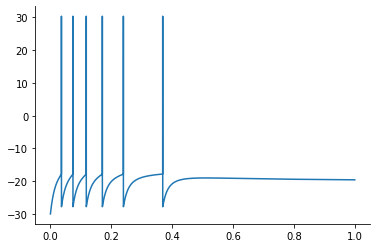

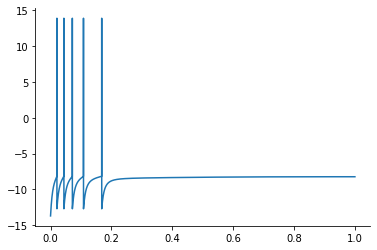

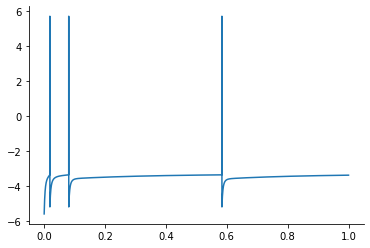

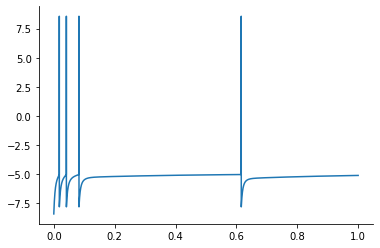

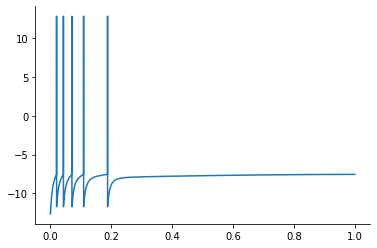

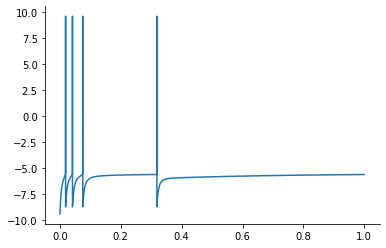

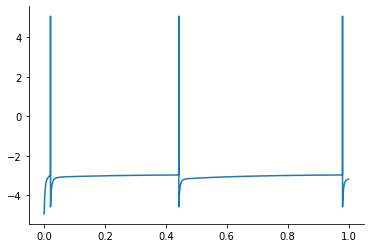

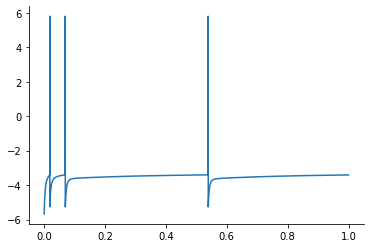

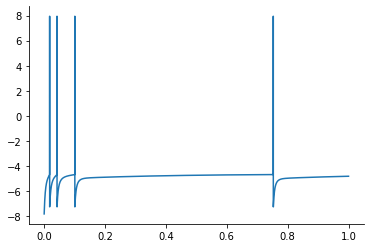

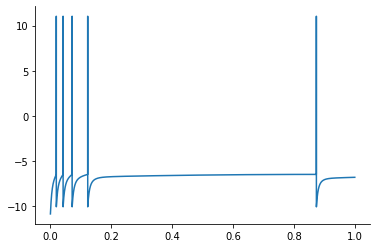

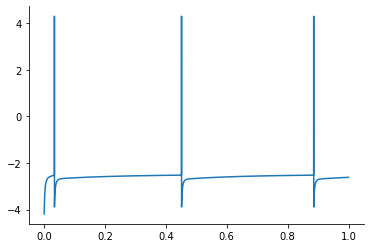

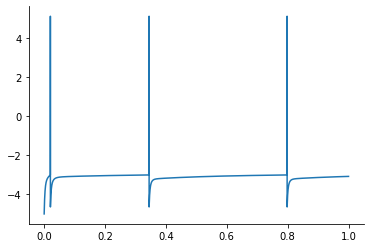

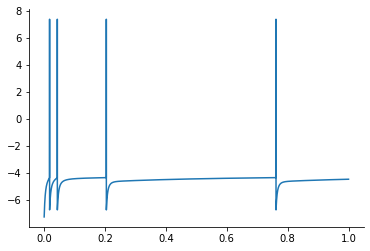

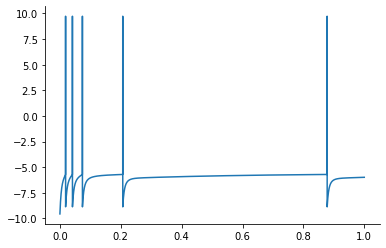

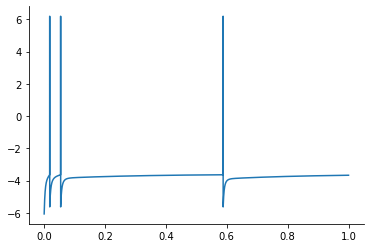

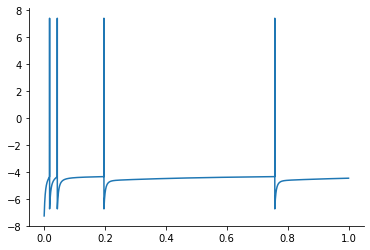

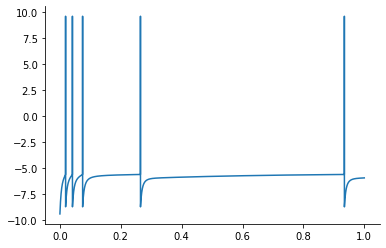

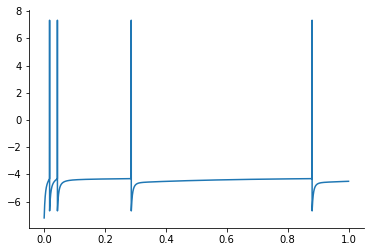

In [7]:



spikes, vs, cs, lambda_vs, lambda_is = run_training(z_in=spikes_in, w_in=w_in, alpha=alpha, target_spikes=6, max_epochs=epochs)

Don't worry that the progress bar turned red, in this case it means that the optimisation
finished early. We can plot the error signals that are propagated backwards in time as follows. At each spike that reaches the neuron at synapse the variable $\lambda_i$ is accumulated to the gradient
of the synaptic weight.

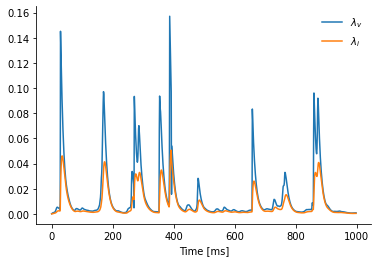

In [8]:
import matplotlib.pyplot as plt

epoch_from_last = 2
plt.plot(lambda_vs[-epoch_from_last][:,0], label='$\lambda_v$')
plt.plot(lambda_is[-epoch_from_last][:,0], label='$\lambda_i$')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

Exercises:
- Change the epoch_from_last variable to plot the error traces at different times in the optimisation
  procedure.
- Change the value alpha. What do you observe?
- Repeat the experiment with more biologically realistic parameters


## Step 2.2: Learning target spike times

Another task is for one neuron to spike at specific spike times $t_0, \ldots, t_N$ given that it stimulated 
by a fixed set of poisson distributed spikes. We can choose as a loss in this case
$$
l = \sum_i \lvert v - v_{\text{th}} \rvert^2 \delta(t - t_i) + l_N
$$
that is we require the membrane voltages to be close to the threshold $v_{th}$ at the required spike times $t_i$
and penalise the neuron if it spikes more or less than the required number of times.

In [9]:
from tqdm.notebook import trange

def run_target_spike_time_training(
    w_in,
    z_in,
    alpha=100.0,
    epochs=40000,
    target_times=[100, 300, 500, 700]
):
    print("w_in",w_in)
    neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=len(target_times))
    params = neurons.parameters()

    optim = torch.optim.SGD(params, lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []
    

    v_target = torch.zeros(seq_length, batch_size, hidden_size)
    target_spikes = len(target_times)

    for time in target_times:  
        v_target[time,:] = 1.1 * torch.ones(hidden_size)
    
    pbar = trange(epochs)
    for e in pbar:
        optim.zero_grad()
        z_s, voltages, currents, concise_spk_times = neurons(z_in)
        loss = torch.zeros(1,1)
        
        print(target_times)
        rescale = []
        if len(concise_spk_times):
            for gt,time in zip(target_times,concise_spk_times):
                tt = gt/1000.0
                rescale.append(tt)
                temp = 1/2 * 1/10 * (float(time)-tt)**2
                loss += temp
            print(rescale)
            print(concise_spk_times)

        else:
            for time in target_times:    
                loss += 10000.0
        dspikes = np.sum(len(concise_spk_times) - target_spikes)
        loss += dspikes                
        print(loss)

        loss_ = loss
        loss = torch.zeros(1,1)

        loss = loss_
        loss.requres_grad = True

        loss.backward()

        #pbar.set_postfix({"loss": loss.detach().item(), "spike difference": dspikes.detach().item()})

        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)
        spikes_out.append(z_s.detach().data)
        #lambda_vs.append(torch.stack(neurons.lambda_vs))
        #lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.lambda_vs = []
        neurons.lambda_is = []
        if loss==0.0:
            #if loss.data == torch.tensor([0.0]):
            break

        optim.step()


    return spikes_out, vs, vs, lambda_vs, lambda_is

In [10]:
"""
neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)
params = neurons.parameters()
print([p for p in params])
params = neurons.parameters()

optim = torch.optim.SGD(params, lr=0.1)
print(neurons.p)
print(w_in)
"""

'\nneurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)\nparams = neurons.parameters()\nprint([p for p in params])\nparams = neurons.parameters()\n\noptim = torch.optim.SGD(params, lr=0.1)\nprint(neurons.p)\nprint(w_in)\n'

In [11]:
seq_length = 1000
input_size = 150
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0
target_times = [100, 300, 500, 700]


#w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)

w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
w_in = [abs(i)/2.0 for i in w_in]
w_in
print(w_in)

[array([3.66383842e-01, 5.13461764e-01, 6.54537806e-01, 2.44115827e-02,
       6.55312894e-01, 3.49370947e-01, 8.51230347e-01, 3.23485066e-02,
       1.68814220e+00, 5.59824111e-01, 5.90425033e-01, 1.06915797e+00,
       4.11135449e-01, 2.01227409e-01, 3.12804876e-01, 1.55606573e+00,
       2.36561041e-01, 1.87820726e-01, 6.67427790e-02, 7.51506827e-01,
       4.55373453e-01, 1.05959007e+00, 3.69449787e-01, 9.86784302e-01,
       2.98927931e-01, 2.96033357e-01, 1.14884144e+00, 2.27284144e-01,
       7.97193211e-01, 4.48241710e-01, 7.79584378e-01, 3.45769607e-01,
       1.93630379e-01, 9.16204236e-01, 9.76762794e-01, 4.09296735e-01,
       5.96789151e-01, 1.41758004e-01, 2.91408888e-01, 6.45542055e-01,
       1.85154245e-01, 3.51523994e-01, 3.80620039e-01, 4.98443632e-01,
       2.04602608e-01, 3.83103770e-01, 1.76752853e+00, 3.00478498e-01,
       5.53505830e-02, 5.80502837e-01, 7.77402277e-01, 2.81014264e-01,
       2.66871420e-02, 6.04472276e-02, 2.59284454e-01, 8.28912911e-01,
     

w_in [array([3.66383842e-01, 5.13461764e-01, 6.54537806e-01, 2.44115827e-02,
       6.55312894e-01, 3.49370947e-01, 8.51230347e-01, 3.23485066e-02,
       1.68814220e+00, 5.59824111e-01, 5.90425033e-01, 1.06915797e+00,
       4.11135449e-01, 2.01227409e-01, 3.12804876e-01, 1.55606573e+00,
       2.36561041e-01, 1.87820726e-01, 6.67427790e-02, 7.51506827e-01,
       4.55373453e-01, 1.05959007e+00, 3.69449787e-01, 9.86784302e-01,
       2.98927931e-01, 2.96033357e-01, 1.14884144e+00, 2.27284144e-01,
       7.97193211e-01, 4.48241710e-01, 7.79584378e-01, 3.45769607e-01,
       1.93630379e-01, 9.16204236e-01, 9.76762794e-01, 4.09296735e-01,
       5.96789151e-01, 1.41758004e-01, 2.91408888e-01, 6.45542055e-01,
       1.85154245e-01, 3.51523994e-01, 3.80620039e-01, 4.98443632e-01,
       2.04602608e-01, 3.83103770e-01, 1.76752853e+00, 3.00478498e-01,
       5.53505830e-02, 5.80502837e-01, 7.77402277e-01, 2.81014264e-01,
       2.66871420e-02, 6.04472276e-02, 2.59284454e-01, 8.28912911e-01,


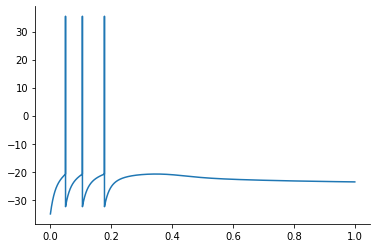

[100, 300, 500, 700]
[0.1, 0.3, 0.5]
[0.0496 0.1051 0.1775] s
tensor([[-0.9928]])



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [12]:


spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
result = run_target_spike_time_training(
    w_in=w_in, 
    z_in=z_in,
    alpha=alpha, 
    epochs=epochs, 
    target_times=target_times
)

In [ ]:
spikes, vs, cs, lambda_vs, lambda_is = result

actual_times = spikes[-1][:,0,0].to_sparse().indices()[0]


for ts in target_times:
    plt.axvline(x=ts, color='red', linestyle='--')

for ts in list(actual_times):
    plt.axvline(x=ts, color='blue', linestyle='-')

plt.plot(vs[-1][:,0], color='grey', label='$v$')
plt.xlabel('Time [ms]')
plt.legend()

We again visualise the error traces over time.

In [ ]:
plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.xlabel('Time [ms]')
plt.legend()

Exercises:
- This task doesn't actually do great, can you think of ways to improve it?
- What additions to the loss could one consider to make the task more stable?
- Explore different values for alpha, target_times and input size, what do you observe?
- Consider a different optimiser
- Consider using biologically plausible neuron parameters